In [3]:
from math import exp, log
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('shared_car_locations/2020_02_25.csv')

In [88]:
time = df['timestamp'].drop_duplicates().sort_values().reset_index(drop=True)
time.head(5)

0    2018-07-04 00:04:24 UTC
1    2018-07-04 00:09:26 UTC
2    2018-07-04 00:14:28 UTC
3    2018-07-04 00:19:30 UTC
4    2018-07-04 00:24:33 UTC
Name: timestamp, dtype: object

In [ ]:
count_per_timestamp = []
for i in range(1000):
    count_per_timestamp.append(df.loc[df.timestamp == time[i]]['total_cars'].sum())

In [ ]:
plt.plot(count_per_timestamp)
plt.show()

In [ ]:
df = df.loc[df.total_cars > 0]

In [ ]:
df = df.sort_values(['timestamp'])

In [ ]:
data = df.loc[df.timestamp <= time[1000]].reset_index(drop=True)
data.head(5)

In [ ]:
data.to_csv('shared_car_locations/shared_car_locations.csv')

In [3]:
df = pd.read_csv('shared_car_locations/shared_car_locations.csv', index_col=0)
df.head(5)

,latitude,longitude,total_cars,cars_list,timestamp
0,32.109660,34.824740,1,[6],2018-07-04 00:04:24 UTC
1,32.098600,34.788400,1,[90],2018-07-04 00:04:24 UTC
2,32.086678,34.791337,1,[88],2018-07-04 00:04:24 UTC
3,32.047100,34.778290,1,[67],2018-07-04 00:04:24 UTC
4,32.121600,34.820270,1,[63],2018-07-04 00:04:24 UTC


In [6]:
latitude_min = 32.045
longitude_min = 34.76

latitude_step = 0.0027 # 300m
longitude_step = 0.00318 # 300m

latitude_num = 15
longitude_num = 15
latitude_max = latitude_min + latitude_num*latitude_step
longitude_max = longitude_min + longitude_num*longitude_step

In [5]:
df = df.drop(df[(df['latitude'] < latitude_min) | (df['latitude'] > latitude_max) | (df['longitude'] < longitude_min) | (df['longitude'] > longitude_max)].index).reset_index(drop=True)
df.head(5)

,latitude,longitude,total_cars,cars_list,timestamp
0,32.047100,34.778290,1,[67],2018-07-04 00:04:24 UTC
1,32.047990,34.763400,1,[55],2018-07-04 00:04:24 UTC
2,32.046090,34.799720,1,[35],2018-07-04 00:04:24 UTC
3,32.067507,34.768924,2,"[38, 264]",2018-07-04 00:04:24 UTC
4,32.067037,34.767475,1,[251],2018-07-04 00:04:24 UTC


In [6]:
df['latitude_id'] = df.apply(lambda row : int((row['latitude'] - latitude_min)/latitude_step), axis=1)
df['longitude_id'] = df.apply(lambda row : int((row['longitude'] - longitude_min)/longitude_step), axis=1)
df['location_id'] = df.apply(lambda row : longitude_num*int((row['latitude'] - latitude_min)/latitude_step) + int((row['longitude'] - longitude_min)/longitude_step), axis=1)
df.head(5)

,latitude,longitude,total_cars,cars_list,timestamp,latitude_id,longitude_id,location_id
0,32.047100,34.778290,1,[67],2018-07-04 00:04:24 UTC,0,5,5
1,32.047990,34.763400,1,[55],2018-07-04 00:04:24 UTC,1,1,16
2,32.046090,34.799720,1,[35],2018-07-04 00:04:24 UTC,0,12,12
3,32.067507,34.768924,2,"[38, 264]",2018-07-04 00:04:24 UTC,8,2,122
4,32.067037,34.767475,1,[251],2018-07-04 00:04:24 UTC,8,2,122


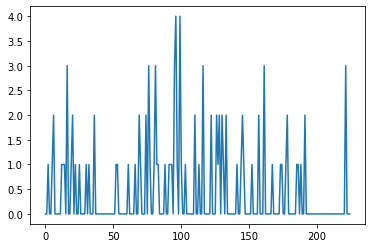

In [24]:
# plt.hist(df[df.timestamp == time[0]]['location_id'], latitude_num*logitude_num)
# plt.plot(df[df.timestamp == time[0]].groupby(['location_id'])['total_cars'].sum())
# from Ipython import display

#for i in range(1000):
plt.cla()
a = np.zeros(latitude_num*logitude_num)
b = df[df.timestamp == time[155]].groupby(['location_id'])['total_cars'].sum()
for i in range(len(a)):
    if i in b.index:
        a[i] = b.loc[i]
plt.plot(a)
# display.clear_output(wait=True)
plt.show()

In [111]:
import folium
from folium.plugins import HeatMap

center = [32.085, 34.800]
m = folium.Map(center, zoom_start=12)

locations = [[latitude_min, longitude_min], [latitude_min, longitude_max],
            [latitude_max, longitude_max], [latitude_max, longitude_min],
            [latitude_min, longitude_min]]

folium.PolyLine(
    locations, # 坐标点列表
    weight=2, # 线宽
    color='black', # 线条颜色
    opacity=0.8 # 透明度
).add_to(m)

latitude_num = int((latitude_max - latitude_min)/latitude_step)
longitude_num = int((longitude_max - longitude_min)/longitude_step)
polygons = []
for i in range(latitude_num):
    latitude_right = latitude_min + latitude_step * (i+1)
    polygons.append([[latitude_right, longitude_min], [latitude_right, longitude_max]])

for i in range(longitude_num):
    longitude_down  = longitude_min + longitude_step * (i+1)
    polygons.append([[latitude_min, longitude_down], [latitude_max, longitude_down]])

folium.PolyLine(
    polygons, # 坐标点列表
    weight=1, # 线宽
    color='black', # 线条颜色
    opacity=0.8 # 透明度
).add_to(m)

df_locations = df.loc[df.timestamp == time[0]].groupby(['latitude', 'longitude', 'timestamp']).sum().reset_index()
for index, row in df_locations.iterrows():
    folium.CircleMarker([row['latitude'], row['longitude']],
                        radius=row['total_cars'] * 6,
                        fill_color="#3db7e4", 
                    ).add_to(m)
    
points = df_locations[['latitude', 'longitude']].values
m.add_child(HeatMap(points, radius=15)) # plot heatmap

m

In [30]:
df.head(5)

,latitude,longitude,total_cars,cars_list,timestamp,latitude_id,longitude_id,location_id
0,32.047100,34.778290,1,[67],2018-07-04 00:04:24 UTC,0,5,5
1,32.047990,34.763400,1,[55],2018-07-04 00:04:24 UTC,1,1,16
2,32.046090,34.799720,1,[35],2018-07-04 00:04:24 UTC,0,12,12
3,32.067507,34.768924,2,"[38, 264]",2018-07-04 00:04:24 UTC,8,2,122
4,32.067037,34.767475,1,[251],2018-07-04 00:04:24 UTC,8,2,122


In [50]:
import json

single_car_df = pd.DataFrame(columns=['timestamp', 'location_id', 'car_id'])
for i in range(len(df)):
    cars = json.loads(df.loc[i]['cars_list'])
    for car in cars:
        single_car_df = single_car_df.append({'timestamp':df.loc[i]['timestamp'], 'location_id':df.loc[i]['location_id'], 'car_id':car}, ignore_index=True)


# exp

In [4]:
single_car_df = pd.read_csv('shared_car_locations/single_car.csv', index_col=0)

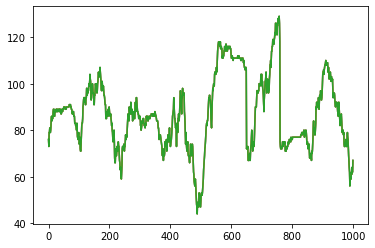

In [85]:
count_per_timestamp = []
for i in range(1000):
    count_per_timestamp.append(single_car_df.loc[single_car_df.timestamp == time[i]].count())
plt.plot(count_per_timestamp)
plt.show()

In [7]:
from geopy.distance import geodesic

d = latitude_num*longitude_num
coordinate = np.zeros((d, 2))
for i in range(d):
    coordinate[i] = ((latitude_min + latitude_step*int(i/longitude_num) + latitude_step/2), (longitude_min + longitude_step*i%longitude_num + longitude_step/2))
dist_mat = np.zeros((d, d))
for i in range(d):
    for j in range(d):
        dist_mat[i][j] = geodesic(coordinate[i], coordinate[j]).m
# dist_mat /= geodesic(coordinate[0], coordinate[1]).m

In [27]:
alpha = 0.0039
d = 225
data = np.array(single_car_df['location_id'])
freq = np.zeros(d)
for i in data:
    freq[i] += 1
freq /= freq.sum()
p_mat = np.exp(-alpha*dist_mat/2)
for i, _ in enumerate(p_mat):
    p_mat[i] /= p_mat[i].sum()
(freq.T*dist_mat*p_mat).sum()

485.92501398180286

In [28]:
from math import exp

epsilon = 8.24
p_mat_grr = np.full((d, d), 1/(exp(epsilon) + d - 1))
p_mat_grr[np.diag_indices_from(p_mat_grr)] = exp(epsilon)/(exp(epsilon) + d - 1)
(freq*(dist_mat*p_mat_grr).sum(axis=1)).sum()

1223.7908395358559

In [254]:
data = np.array(single_car_df.loc[single_car_df.timestamp==time[0]]['location_id'])
freq = np.arange(d)
for i in data:
    freq[i] += 1

Counter({122: 4, 77: 3, 99: 3, 168: 3, 133: 3, 5: 2, 139: 2, 215: 2, 100: 2, 221: 2, 64: 2, 6: 2, 140: 2, 47: 2, 191: 2, 169: 2, 16: 1, 12: 1, 141: 1, 83: 1, 87: 1, 153: 1, 75: 1, 33: 1, 187: 1, 205: 1, 220: 1, 103: 1, 55: 1, 155: 1, 74: 1, 177: 1, 22: 1, 136: 1, 171: 1, 161: 1, 27: 1, 25: 1, 173: 1, 92: 1, 219: 1, 63: 1, 119: 1, 154: 1, 91: 1, 37: 1, 78: 1, 218: 1, 59: 1, 62: 1, 69: 1, 48: 1, 89: 1, 14: 1})


array([  5,  16,  12, 122, 141,  83,  87, 153,  75, 139,  77, 215, 100,
        33, 221,  64,  99, 187, 205, 220, 103,  55,   6, 155,  74, 140,
       168, 177,  22, 136, 171, 161,  27,  25, 173,  92, 219,  63,  47,
       191, 119, 133, 154,  91,  37,  78, 218,  59,  62, 169,  69,  48,
        89,  14])

[122  77  99 168 133   5 139 215 100 221  64   6 140  47 191 169  16  12
 141  83  87 153  75  33 187 205 220 103  55 155  74 177  22 136 171 161
  27  25 173  92 219  63 119 154  91  37  78 218  59  62] [ 88  77 220 100 102 133  59 174   9  17  12 122 123 124 135  83 158 145
 139  82 218  99  31 222  56  66 194 208 219  55   3 157 138 142 163 176
  23 118 134 168 161  25  14 172  79  62  38  46 198 195]
50 50
0.20481927710843373


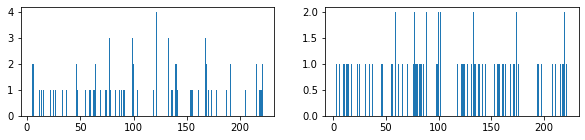

In [312]:
from collections import Counter

def EM(data, d, alpha, dist):
    p_mat = np.exp(-alpha*dist/2)
    for i, _ in enumerate(p_mat):
        p_mat[i] /= p_mat[i].sum()
    universe = np.arange(d)
    private_data = np.zeros_like(data)
    for i, item in enumerate(data):
        private_data[i] = np.random.choice(universe, p=p_mat[item])
    return private_data

def utility(data, private_data):
    k = 50
    true_top_k = np.array(Counter(data).most_common(k))[:, 0]
    est_top_k = np.array(Counter(private_data).most_common(k))[:, 0]
    print(true_top_k, est_top_k)
    print(len(true_top_k), len(est_top_k))
    jaccard = len(np.intersect1d(true_top_k, est_top_k))/len(np.union1d(true_top_k, est_top_k))
    return jaccard

alpha = 0.002
d = latitude_num*longitude_num


data = np.array(single_car_df.loc[single_car_df.timestamp==time[0]]['location_id'])
private_data = EM(data, d, alpha, dist_mat)
print(utility(data, private_data))

plt.figure(figsize=(10, 2))
plt.subplot(121)
plt.hist(data, d)
plt.subplot(122)
plt.hist(private_data, d)
plt.show()

In [247]:
k = 50
w = 10
alpha = 1

record = np.zeros_like(time)
for i, t in enumerate(time):
    data = np.array(single_car_df.loc[single_car_df.timestamp==t]['location_id'])
    private_data = EM(data, d, alpha, dist_mat)
    record[i] = utility(data, private_data)
print(record.mean())

0.26297507482414273


In [242]:
record

array([None, None, None, ..., None, None, None], dtype=object)